# Centroid grid predictions

Classify test data using centroid probabilities for grid of tiles.
We're using probabilities for the entire test image.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark(cores=4)
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/20 17:12:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/20 17:12:54 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
25/04/20 17:12:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Sun Apr 20 05:12:56 PM EDT 2025


### Faiss centroid probabilities 

In [4]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/embeddings"


# Define the path to the train and test parquet files
def get_faiss_embed_path(num_centroids: int = 10):
    return f"{data_path}/train_centroids/num_centroids={num_centroids}"


# Read the parquet files into a spark DataFrame
faiss10_df = spark.read.parquet(get_faiss_embed_path(10))
faiss20_df = spark.read.parquet(get_faiss_embed_path(20))
faiss50_df = spark.read.parquet(get_faiss_embed_path(50))

# Show the data
faiss10_df.printSchema()
faiss10_df.show(n=5)

root
 |-- centroid_id: integer (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)



+-----------+----------+--------------------+
|centroid_id|species_id|           embedding|
+-----------+----------+--------------------+
|          6|   1398243|[1.0948665, -0.35...|
|          7|   1647175|[-0.30202305, 0.7...|
|          3|   1360020|[0.049416766, 0.9...|
|          3|   1361527|[0.3046188, 0.885...|
|          8|   1359277|[-0.09973065, 0.6...|
+-----------+----------+--------------------+
only showing top 5 rows



In [13]:
test_path = f"{data_path}/embeddings/test_2025/test_2025_grid=4x4"
test_df = spark.read.parquet(test_path)
test_df = test_df.orderBy(["image_name", "tile_index"])
test_df.printSchema()
test_df.show(n=16)

root
 |-- image_name: string (nullable = true)
 |-- output: struct (nullable = true)
 |    |-- cls_token: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- logits: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |-- tile_index: integer (nullable = true)
 |-- sample_id: integer (nullable = true)



+--------------------+--------------------+----------+---------+
|          image_name|              output|tile_index|sample_id|
+--------------------+--------------------+----------+---------+
|2024-CEV3-2024060...|{[-0.61463046, -0...|         0|        0|
|2024-CEV3-2024060...|{[0.28768584, -0....|         1|        0|
|2024-CEV3-2024060...|{[-0.02235908, -0...|         2|        0|
|2024-CEV3-2024060...|{[0.8427155, 0.25...|         3|        0|
|2024-CEV3-2024060...|{[-1.5083455, 0.7...|         4|        0|
|2024-CEV3-2024060...|{[-1.211987, 0.51...|         5|        0|
|2024-CEV3-2024060...|{[-0.8227187, -0....|         6|        0|
|2024-CEV3-2024060...|{[-0.8875058, 1.0...|         7|        0|
|2024-CEV3-2024060...|{[-1.5578709, 1.3...|         8|        0|
|2024-CEV3-2024060...|{[-0.65859604, 1....|         9|        0|
|2024-CEV3-2024060...|{[-0.24108684, -0...|        10|        0|
|2024-CEV3-2024060...|{[-1.2887176, 0.3...|        11|        0|
|2024-CEV3-2024060...|{[-

In [16]:
test_df.count()  # 2105 * 16 = 33680 (4x4 tiles)

33680

In [14]:
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType


def avg_embeddings_udf(embeddings):
    array = np.array(embeddings)
    mean_array = np.mean(array, axis=0)
    return mean_array.tolist()


average_embeddings = F.udf(avg_embeddings_udf, ArrayType(FloatType()))

# group and apply the UDF
avg_embeddings_df = (
    faiss10_df.groupBy("species_id")
    .agg(F.collect_list("embedding").alias("embedding_list"))
    .withColumn("avg_embeddings", average_embeddings(F.col("embedding_list")))
)
avg_embeddings_df.printSchema()
avg_embeddings_df.show(n=10, truncate=50)

root
 |-- species_id: integer (nullable = true)
 |-- embedding_list: array (nullable = false)
 |    |-- element: array (containsNull = false)
 |    |    |-- element: float (containsNull = true)
 |-- avg_embeddings: array (nullable = true)
 |    |-- element: float (containsNull = true)



+----------+--------------------------------------------------+--------------------------------------------------+
|species_id|                                    embedding_list|                                    avg_embeddings|
+----------+--------------------------------------------------+--------------------------------------------------+
|   1355869|[[0.0038829704, -0.013802218, 0.009791469, 0.36...|[0.114047855, 0.4057617, -0.06062866, 0.0549097...|
|   1355870|[[0.18335515, -0.08915622, -0.29222322, 0.81695...|[0.11070547, 0.28042978, -0.69385886, 0.3224701...|
|   1355872|[[0.28893483, 0.20109488, 0.24363865, 0.2530085...|[0.19194208, 0.1617909, -0.013561882, 0.1457786...|
|   1355881|[[0.23531002, -0.26157096, -0.017927974, -1.038...|[0.20774464, -0.2938113, 0.026279427, -0.838810...|
|   1355900|[[1.0873219, -0.07327607, -0.29321098, 0.071418...|[0.5382732, 0.15868045, -0.116654, 0.23893037, ...|
|   1355953|[[-0.4760781, 1.7744097, -1.1470047, -0.3837139...|[-0.016290855, 0.

### classifier-based probabilities

Calculate probabilities based on embedding distances

In [15]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.special import softmax
from plantclef.config import get_class_mappings_file

# load class mappings
class_mappings_file = get_class_mappings_file()
with open(class_mappings_file) as f:
    sorted_species_ids = [int(line.strip()) for line in f]

# get (species_id, avg_embeddings) from Spark
centroids_pd = avg_embeddings_df.select("species_id", "avg_embeddings").toPandas()

# filter + reorder centroids to match sorted_species_ids
centroids_dict = dict(zip(centroids_pd["species_id"], centroids_pd["avg_embeddings"]))
filtered_embeddings = [
    centroids_dict[species_id]
    if species_id in centroids_dict
    else np.zeros_like(next(iter(centroids_dict.values())))
    for species_id in sorted_species_ids
]

# shape: (num_species, embedding_dim)
train_embeddings = np.stack(filtered_embeddings)
train_embeddings.shape

(7806, 768)

In [17]:
# get test embeddings and image names
test_pd = test_df.select("image_name", "output.cls_token").toPandas()
test_embeddings = np.stack(test_pd["cls_token"].values)
image_names = test_pd["image_name"].values

# compute cosine similarity and softmax
cos_similarities = cosine_similarity(test_embeddings, train_embeddings)
eucliden_dist = euclidean_distances(test_embeddings, train_embeddings)
euclidean_score = (1 / (eucliden_dist**2)) / np.sum(
    1 / (eucliden_dist**2), axis=1, keepdims=True
)  # normalize to sum to 1
cos_probabilities = softmax(cos_similarities, axis=1)  # shape: (num_test, num_species)

# create final DataFrame with aligned probabilities
final_df = pd.DataFrame(
    {
        "image_name": image_names,
        "cos_probabilities": list(cos_probabilities),
        "euclidean_score": list(euclidean_score),
    }
)
final_df.head()

,image_name,cos_probabilities,euclidean_score
0,2024-CEV3-20240602.jpg,"[0.00012163771, 0.00013207976, 0.00012214911, ...","[0.00013247246, 0.0001367882, 0.00013204469, 0..."
1,2024-CEV3-20240602.jpg,"[0.00012493311, 0.00012987839, 0.0001212271, 0...","[0.00013578957, 0.0001351673, 0.0001316694, 0...."
2,2024-CEV3-20240602.jpg,"[0.00012196221, 0.00012778373, 0.00012331233, ...","[0.00013204673, 0.00013252249, 0.00013235239, ..."
3,2024-CEV3-20240602.jpg,"[0.0001220392, 0.00013172043, 0.00012257454, 0...","[0.00013307533, 0.00013671836, 0.00013264263, ..."
4,2024-CEV3-20240602.jpg,"[0.00012535114, 0.000132837, 0.00012940155, 0....","[0.00013457047, 0.00013656596, 0.00013702415, ..."


In [18]:
len(final_df)  # 33680

33680

In [19]:
final_spark_df = spark.createDataFrame(final_df)
# get 20 random rows
rows = final_spark_df.orderBy(F.rand()).limit(100).collect()
euclidean_scores = [row.euclidean_score for row in rows]

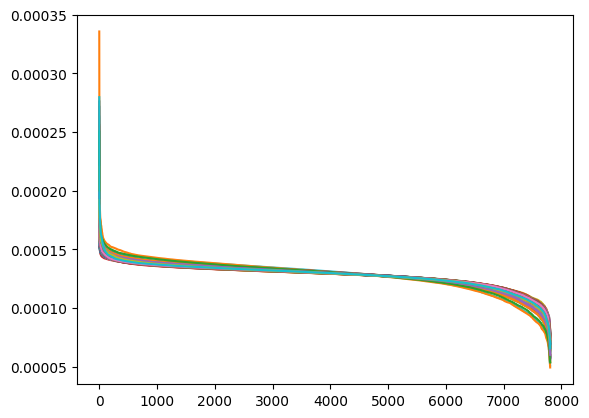

In [20]:
import matplotlib.pyplot as plt


for row in euclidean_scores:
    plt.plot(sorted(row, reverse=True))
plt.show()

### write to parquet

In [21]:
# convert pandas to spark DataFrame
final_spark_df = spark.createDataFrame(final_df)
final_spark_df = final_spark_df.select(
    "image_name", F.col("euclidean_score").alias("prior_probabilities")
)
final_spark_df.printSchema()
final_spark_df.show(n=5, truncate=50)

# write the DataFrame to parquet
folder_name = "test_2025_tile_prior_probabilities"
output_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/prior/{folder_name}"
final_spark_df.write.mode("overwrite").parquet(output_path)
print(f"Probabilities saved to {output_path}")

root
 |-- image_name: string (nullable = true)
 |-- prior_probabilities: array (nullable = true)
 |    |-- element: float (containsNull = true)



+----------------------+--------------------------------------------------+
|            image_name|                               prior_probabilities|
+----------------------+--------------------------------------------------+
|2024-CEV3-20240602.jpg|[1.3247246E-4, 1.367882E-4, 1.3204469E-4, 1.269...|
|2024-CEV3-20240602.jpg|[1.3578957E-4, 1.351673E-4, 1.316694E-4, 1.3092...|
|2024-CEV3-20240602.jpg|[1.3204673E-4, 1.3252249E-4, 1.3235239E-4, 1.29...|
|2024-CEV3-20240602.jpg|[1.3307533E-4, 1.3671836E-4, 1.3264263E-4, 1.30...|
|2024-CEV3-20240602.jpg|[1.3457047E-4, 1.3656596E-4, 1.3702415E-4, 1.37...|
+----------------------+--------------------------------------------------+
only showing top 5 rows



Probabilities saved to /storage/home/hcoda1/9/mgustineli3/p-dsgt_clef2025-0/shared/plantclef/data/prior/test_2025_tile_prior_probabilities
